In [2]:
import pandas as pd

In [5]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.head())
print(df.info())
print(df.describe())
cols = df.columns
print('Unique values in each column')
for col in cols:
    print(f"{col}: {df[col].unique()}")

df.dtypes

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
# Customer Churn Prediction - Notebook
# 1. libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [ ]:
# 2. load data
# replace path with your file path
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")


# quick info
print(df.shape)
print(df.columns)


df.head()


(7043, 21)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# 3. basic cleaning
# Convert TotalCharges to numeric (it may be object because of blanks)
# strip whitespace then coerce
if df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


# check missing
print(df.isnull().sum())
# fill or drop missing TotalCharges
missing_total = df['TotalCharges'].isnull().sum()
if missing_total > 0:
    # For this dataset, missing TotalCharges usually corresponds to tenure=0, set to 0
    df['TotalCharges'].fillna(0, inplace=True)

NameError: name 'np' is not defined

In [5]:
# 4. EDA (brief)
print(df['Churn'].value_counts(normalize=True))


# distribution of numeric features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(df[num_cols].describe())



Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


In [6]:
# 5. Feature selection and preprocessing
# Drop customerID
df = df.drop(columns=['customerID'])


# encode target
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})


def get_categorical_cols(df):
    return [c for c in df.columns if df[c].dtype == 'object']


cat_cols = get_categorical_cols(df)
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']


# Many categorical columns have values like 'No internet service' or 'No phone service' which
# are conceptually the same as 'No' for that feature. Optionally replace them.
replace_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                'StreamingTV','StreamingMovies','MultipleLines']
for c in replace_cols:
    if c in df.columns:
        df[c] = df[c].replace({'No internet service':'No','No phone service':'No'})


# Recompute categorical columns
cat_cols = [c for c in df.columns if df[c].dtype == 'object']


# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.52      0.74      0.61       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.75      0.76      1409

ROC AUC: 0.8393099795913095


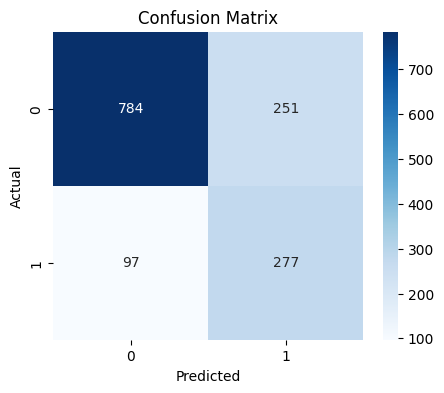

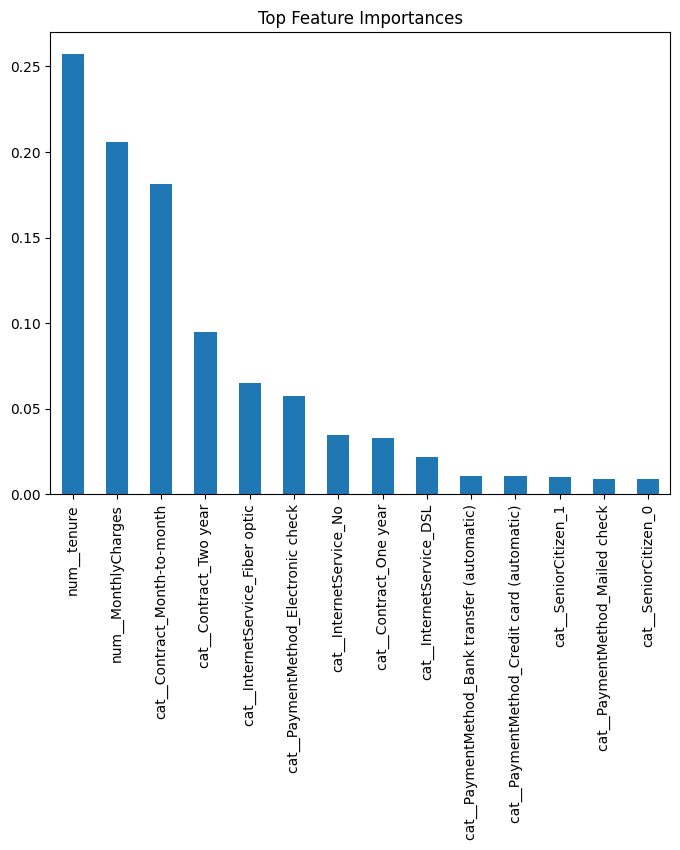

Pipeline saved as 'model_pipeline.joblib'
Sample prediction probabilities: [0.00714593 0.89811097 0.26442686 0.73761493 0.00316214]


In [7]:

# 5. Select 6 features for user-friendly app
selected_cols = ['tenure', 'MonthlyCharges', 'InternetService', 
                 'Contract', 'PaymentMethod', 'SeniorCitizen']
X = df[selected_cols]
y = df['Churn']

# 6. Numeric & categorical columns
numeric_cols = ['tenure', 'MonthlyCharges']
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod', 'SeniorCitizen']

# 7. Train-test split (stratified to keep churn ratio consistent)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# 9. RandomForest + pipeline
rf = RandomForestClassifier(random_state=42, class_weight='balanced')  # handle imbalance

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# 10. GridSearchCV with StratifiedKFold
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv = GridSearchCV(pipeline, param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)
cv.fit(X_train, y_train)

best_pipeline = cv.best_estimator_
print("Best parameters:", cv.best_params_)

# 11. Evaluate on test set
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Feature importances
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    fi = pd.Series(best_pipeline.named_steps['classifier'].feature_importances_,
                   index=feature_names).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    fi.plot(kind='bar')
    plt.title('Top Feature Importances')
    plt.show()

# 13. Save full pipeline for Streamlit app
joblib.dump(best_pipeline, 'model_pipeline.joblib')
print("Pipeline saved as 'model_pipeline.joblib'")

# 14. Quick demo predictions
sample = X_test.iloc[:5]
probs = best_pipeline.predict_proba(sample)[:,1]
print("Sample prediction probabilities:", probs)


In [10]:
for col in selected_cols:
    print(f"{col}: {df[col].unique()}")

tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
InternetService: ['DSL' 'Fiber optic' 'No']
Contract: ['Month-to-month' 'One year' 'Two year']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
SeniorCitizen: [0 1]


In [11]:
pip install langchain_google_genai

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.4 MB 493.7 kB/s eta 0:00:02
   -------------- ------------------------- 0.5/1.4 MB 493.7 kB/s eta 0:00:02
   -------------- ------------------------- 0.5/1.4 MB 493.7 kB/s eta 0:00:02
   ---------------------- ----------------- 0.8/1.4 MB 486.4 kB/s eta 0:00:02
   ---------------------- ----------------- 0.8/1.4 MB 486.4 kB/s eta 0:00:02
   ----------------------------- ---------- 1.0/1.4 MB 498.4 kB/s eta 0:00:01
   ----------------------------- -------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.1 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [54]:
print(X_test[:10])
print("----------------------")
print(y_test[:10])

      tenure  MonthlyCharges InternetService        Contract  \
437       72          114.05     Fiber optic        Two year   
2280       8          100.15     Fiber optic  Month-to-month   
2235      41           78.35             DSL        One year   
4460      18           78.20     Fiber optic  Month-to-month   
3761      72           82.65             DSL        Two year   
5748      21           99.85     Fiber optic  Month-to-month   
3568      21           99.15     Fiber optic  Month-to-month   
2976      19           24.10              No  Month-to-month   
5928      61           19.75              No        Two year   
1639      17           45.05             DSL  Month-to-month   

                  PaymentMethod  SeniorCitizen  
437     Credit card (automatic)              0  
2280    Credit card (automatic)              1  
2235    Credit card (automatic)              0  
4460           Electronic check              0  
3761    Credit card (automatic)              0  
5

In [ ]:
###################################################################################

Best params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1035
           1       0.52      0.72      0.61       374

    accuracy                           0.75      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.79      0.75      0.76      1409

ROC AUC: 0.8358882947118241


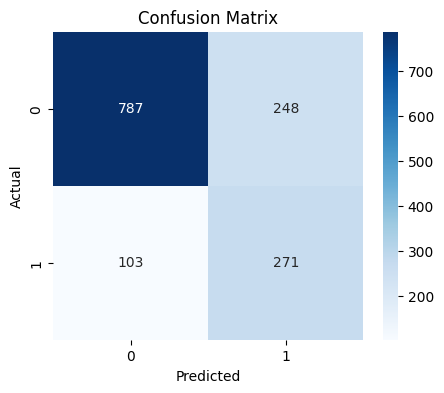

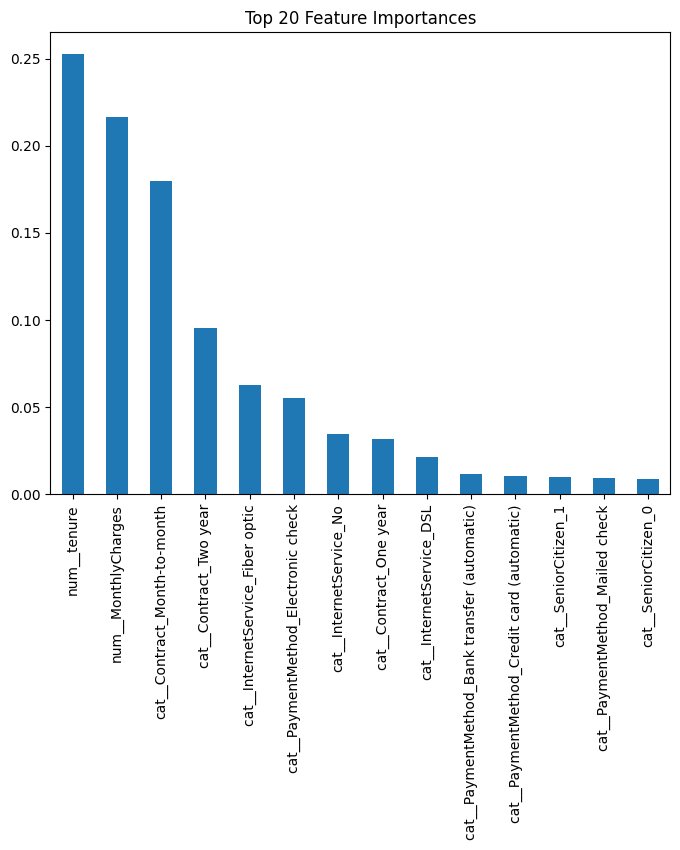

Pipeline saved as 'model_pipeline.joblib'
Sample prediction probabilities: [0.01177088 0.87985757 0.24978399 0.71287688 0.00360946]


In [34]:
# 6. Prepare X and y (only 6 features for user-friendly app)
selected_cols = ['tenure', 'MonthlyCharges', 'InternetService', 
                 'Contract', 'PaymentMethod', 'SeniorCitizen']

X = df[selected_cols]
y = df['Churn']  # already 0/1

# Identify numeric and categorical columns
numeric_cols = ['tenure', 'MonthlyCharges']
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod', 'SeniorCitizen']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7. Preprocessing pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# 8. RandomForest + GridSearchCV pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, class_weight = 'balanced') 
# above class weight is sent to balanced --> because confusion matix was like below
    #            Predicted
    #             0      1
    #  actual 0  933    102
    #  actual 1  187    187
# and most of the predictions were not churn

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

cv = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
cv.fit(X_train, y_train)

best_pipeline = cv.best_estimator_
print("Best params:", cv.best_params_)

# 9. Evaluate on test set
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importances (numeric + categorical after encoding)
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    fi = pd.Series(best_pipeline.named_steps['classifier'].feature_importances_,
                   index=feature_names).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    fi.plot(kind='bar')
    plt.title('Top 20 Feature Importances')
    plt.show()

# 10. Save the full pipeline
import joblib
joblib.dump(best_pipeline, 'model_pipeline.joblib')
print("Pipeline saved as 'model_pipeline.joblib'")

# 11. Quick demo predictions
sample = X_test.iloc[:5]
probs = best_pipeline.predict_proba(sample)[:,1]
print("Sample prediction probabilities:", probs)


Ah! Let’s carefully analyze your **new confusion matrix**:

```
               Predicted.
                0      1
     actual 0  787    248
     actual 1  103    271
```

Where:

* `0` → Not churn
* `1` → Churn

---

### 1️⃣ Compute metrics

**True Positives (TP)** = 271
**True Negatives (TN)** = 787
**False Positives (FP)** = 248
**False Negatives (FN)** = 103

**Recall for churn (sensitivity)**:
[
\text{Recall} = \frac{TP}{TP + FN} = \frac{271}{271 + 103} \approx 0.724
]

* Now the model correctly identifies ~72% of churners ✅

**Precision for churn**:
[
\text{Precision} = \frac{TP}{TP + FP} = \frac{271}{271 + 248} \approx 0.522
]

* Only ~52% of predicted churns are actually churns ⚠

**Accuracy**:
[
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{787 + 271}{787 + 271 + 248 + 103} \approx 0.73
]

---

### 2️⃣ Observations

1. **Recall improved** ✅: More actual churners are detected (good for retention).
2. **Precision dropped** ⚠: More false positives — i.e., the app may alert some “Not churn” customers as churners.
3. **Overall**: This is **acceptable for churn prediction**, because in business, it’s often better to **catch more at-risk customers** (higher recall) even if it includes some false alarms.

---

### 3️⃣ Optional Improvements

* Tune the **decision threshold** (instead of 0.5) to balance recall vs precision.

  * Lower threshold → more TP, higher recall, lower precision.
  * Higher threshold → fewer FP, higher precision, lower recall.
* Use **class_weight='balanced'** in RandomForest (already done?).
* Consider **adding more predictive features** like `TotalCharges`, `PaperlessBilling`, etc. to improve precision.

---

✅ **Conclusion:**

* Yes, this confusion matrix is **much better** than before.
* You are catching the majority of churners (~72%) which is the main goal.
* Some false positives are okay — you can adjust threshold if needed.

---

If you want, I can **suggest a simple threshold adjustment in your Streamlit app** so that it warns users more accurately without overwhelming them with false alerts.

Do you want me to do that?


In [ ]:
print(X_test[:20])
print("----")
print(y_test[:20])



      tenure  MonthlyCharges InternetService        Contract  \
437       72          114.05     Fiber optic        Two year   
2280       8          100.15     Fiber optic  Month-to-month   
2235      41           78.35             DSL        One year   
4460      18           78.20     Fiber optic  Month-to-month   
3761      72           82.65             DSL        Two year   
5748      21           99.85     Fiber optic  Month-to-month   
3568      21           99.15     Fiber optic  Month-to-month   
2976      19           24.10              No  Month-to-month   
5928      61           19.75              No        Two year   
1639      17           45.05             DSL  Month-to-month   
2079      70          106.05     Fiber optic  Month-to-month   
1280      72          114.85     Fiber optic        Two year   
667       49           30.20             DSL  Month-to-month   
3524      11           84.80     Fiber optic  Month-to-month   
5283      19           48.80            

In [23]:
############################################################################

Best params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409

ROC AUC: 0.8409181327339895


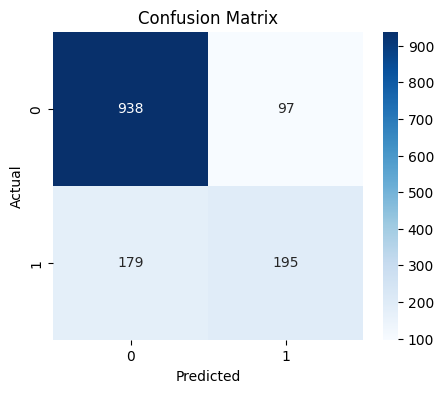

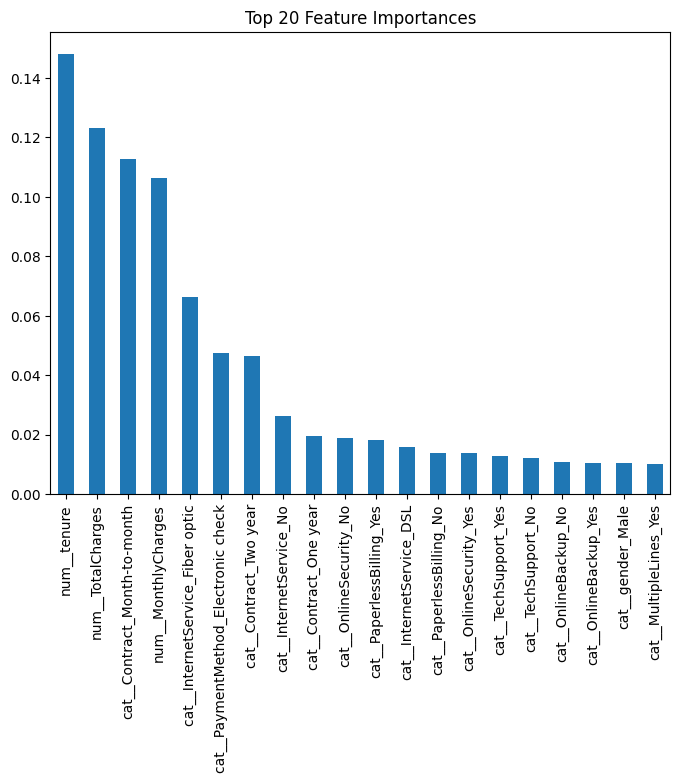

Pipeline saved as 'model_pipeline.joblib'
Sample prediction probabilities: [0.00637658 0.71967933 0.06436443 0.32703093 0.0174344 ]


In [15]:
# 6. Prepare X and y
X = df.drop(columns=['Churn'])
y = df['Churn']  # already 0/1

# Identify numeric and categorical columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Optional: fix 'No internet service' / 'No phone service' values
replace_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                'StreamingTV','StreamingMovies','MultipleLines']
for c in replace_cols:
    if c in X.columns:
        X[c] = X[c].replace({'No internet service':'No','No phone service':'No'})

# Recompute categorical columns after replacements
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7. Preprocessing pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# 8. RandomForest + GridSearchCV pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

cv = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
cv.fit(X_train, y_train)

best_pipeline = cv.best_estimator_
print("Best params:", cv.best_params_)

# 9. Evaluate on test set
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importances (numeric + categorical after encoding)
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    fi = pd.Series(best_pipeline.named_steps['classifier'].feature_importances_,
                   index=feature_names).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    fi.plot(kind='bar')
    plt.title('Top 20 Feature Importances')
    plt.show()

# 10. Save the full pipeline
import joblib
joblib.dump(best_pipeline, 'model_pipeline.joblib')
print("Pipeline saved as 'model_pipeline.joblib'")

# 11. Quick demo predictions
sample = X_test.iloc[:5]
probs = best_pipeline.predict_proba(sample)[:,1]
print("Sample prediction probabilities:", probs)


In [ ]:
###############################################################################

In [8]:
# For categorical: use one-hot encoding via pandas.get_dummies later for simplicity


# 6. Prepare X, y
X = df.drop(columns=['Churn'])
y = df['Churn']


# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)
print('X shape after dummies:', X.shape)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Scale numeric features (after split)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X shape after dummies: (7043, 23)


In [9]:
# 7. Baseline models and evaluation helpers
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}


results = {}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    results[name] = {'accuracy':acc,'precision':prec,'recall':rec,'f1':f1,'roc_auc':roc}


pd.DataFrame(results).T

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.805536,0.658228,0.556150,0.602899,0.842233
RandomForest,0.792761,0.639456,0.502674,0.562874,0.829545
SVM,0.794890,0.653430,0.483957,0.556068,0.798215
KNN,0.762952,0.553763,0.550802,0.552279,0.791904


Best params {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC: 0.8429628768503448


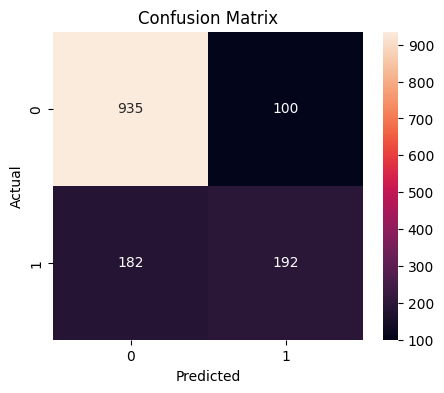

tenure                            0.193667
TotalCharges                      0.159032
MonthlyCharges                    0.133147
InternetService_Fiber optic       0.078121
PaymentMethod_Electronic check    0.068665
Contract_Two year                 0.061820
InternetService_No                0.037665
Contract_One year                 0.032673
OnlineSecurity_Yes                0.028547
PaperlessBilling_Yes              0.027206
TechSupport_Yes                   0.024567
MultipleLines_Yes                 0.016520
OnlineBackup_Yes                  0.016065
SeniorCitizen                     0.016051
gender_Male                       0.014580
Partner_Yes                       0.014156
Dependents_Yes                    0.013879
StreamingTV_Yes                   0.013093
StreamingMovies_Yes               0.012636
DeviceProtection_Yes              0.012203
dtype: float64


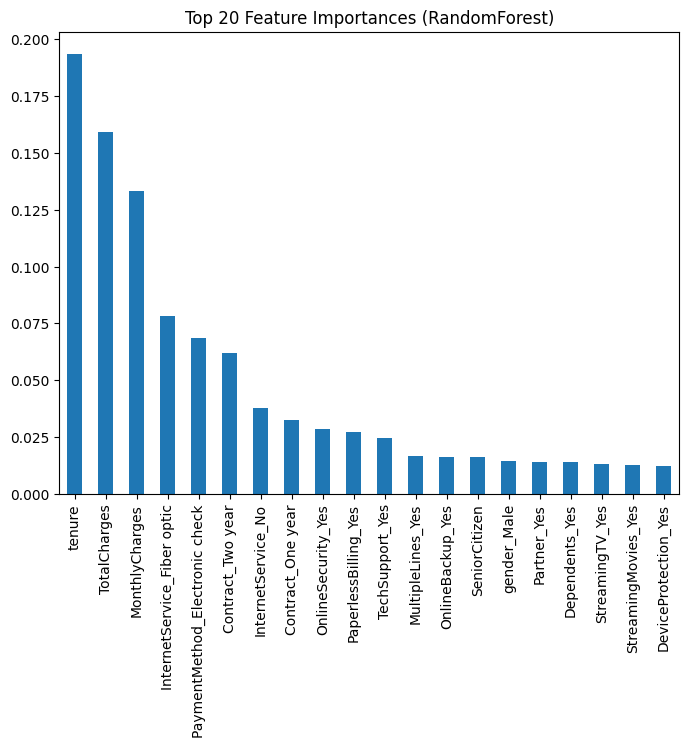

[0.01719655 0.77195356 0.10155463 0.34117099 0.02148563]


In [ ]:
# 8. Choose best model (example: RandomForest) and tune with GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300, 500, 700, 1000],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': [None, 10, 20, 30, 50, 70, 100],
#     'min_samples_split': [2, 5, 10, 15, 20],
#     'min_samples_leaf': [1, 2, 4, 6, 8],
#     'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5, 0.7],
#     'bootstrap': [True, False],
#     'class_weight': [None, 'balanced', 'balanced_subsample'],
#     'max_samples': [None, 0.5, 0.7, 0.9],  # used only when bootstrap=True
#     'oob_score': [True, False]  # out-of-bag validation for bootstrap=True
# }

param_grid = {
    'n_estimators':[100,200],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5]
}

rf = RandomForestClassifier(random_state=42)
cv = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
cv.fit(X_train, y_train)
print('Best params', cv.best_params_)
best_rf = cv.best_estimator_


# Evaluate best
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))


# Confusion matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 9. Feature importance
fi = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
print(fi)
plt.figure(figsize=(8,6))
fi.plot(kind='bar')
plt.title('Top 20 Feature Importances (RandomForest)')
plt.show()


# 10. Save model and scaler
joblib.dump({'model':best_rf,'scaler':scaler, 'features': X_train.columns.tolist()}, 'model.joblib')


# 11. Quick predictions demo
sample = X_test.iloc[:5]
loaded = joblib.load('model.joblib')
probs = loaded['model'].predict_proba(sample)[:,1]
print(probs)
